## Reading Data

In [192]:
import os
import cv2
from tensorflow.keras.utils import to_categorical

CLASSES = ["flooded", "non-flooded"]
SIZE = (512, 512)

def load_data(data_path):
    data = []
    labels = []
    for c in CLASSES:
        path = os.path.join(data_path, c)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            img_array = cv2.resize(img_array, SIZE)
            data.append(img_array)
            labels.append(CLASSES.index(c))

    labels = to_categorical(labels)
    return data, labels


# Load data
data, labels = load_data("./Dataset")

## Splitting Data

In [193]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)


## Preprocessing

In [194]:
import imgaug.augmenters as iaa
import numpy as np
import random

def data_augmentation(data, labels):
    augmented_images = []
    augmented_labels = []
    seqs = []
    # Define the augmentation sequences
    for i in range(1):
        seq = iaa.Sequential([
                iaa.Fliplr(p=random.choice([0, 90]) / 360),
                iaa.Flipud(p=random.choice([0, 90]) / 360),
                # iaa.Crop(percent=(0, random.uniform(0, 0.1))),
                iaa.GaussianBlur(sigma=random.uniform(0, 3.0)),
                iaa.AdditiveGaussianNoise(scale=random.uniform(0.01,0.06)*255),
                # iaa.Multiply((random.uniform(0.5, 1.5), random.uniform(0.5, 1.5))),
                # iaa.Affine(
                    # scale={"x": (random.uniform(0.8, 1.2), random.uniform(0.8, 1.2)), "y": (random.uniform(0.8, 1.2), random.uniform(0.8, 1.2))},
                    # translate_percent={"x": (random.uniform(-0.2, 0.2), random.uniform(-0.2, 0.2)), "y": (random.uniform(-0.2, 0.2), random.uniform(-0.2, 0.2))},
                    # rotate=(random.uniform(-45, 45), random.uniform(-45, 45)),
                    # shear=(random.uniform(-16, 16), random.uniform(-16, 16))
                # )
                ], random_order=True)
        seqs.append(seq)

    for i, image in enumerate(data):
        augmented_images.append(image)
        augmented_labels.append(labels[i])
        for seq in seqs:
            augmented_image = seq(image=image)
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])
    
    return np.array(augmented_images), np.array(augmented_labels)


In [196]:
# apply augmentation on training data
X_train_aug, y_train = data_augmentation(X_train, y_train)

# apply augmentation on validation data
X_val_aug, y_val = data_augmentation(X_val, y_val)

## Model

### Model Building

In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Conv2D,
    AveragePooling2D,
    Flatten,
    Dense,
    Activation,
    MaxPool2D,
    BatchNormalization,
    Dropout,
)
from tensorflow.keras.utils import to_categorical

In [200]:
model = Sequential()
# 1st layer (CONV + pool + batchnorm)
model.add(
    Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides=(2, 2),
        padding="same",
        input_shape=(SIZE[0], SIZE[1], 3),
    )
)
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# 2nd layer (CONV + pool + batchnorm)
model.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding="same",
        kernel_regularizer=l2(0.0005),
    )
)
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), padding="valid"))
model.add(BatchNormalization())
# layer 3 (CONV + batchnorm)
model.add(
    Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding="same",
        kernel_regularizer=l2(0.0005),
    )
)
model.add(Activation("relu"))
model.add(BatchNormalization())
# layer 4 (CONV + batchnorm)
model.add(
    Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding="same",
        kernel_regularizer=l2(0.0005),
    )
)
model.add(Activation("relu"))
model.add(BatchNormalization())
# layer 5 (CONV + batchnorm)
model.add(
    Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding="same",
        kernel_regularizer=l2(0.0005),
    )
)
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding="valid"))
model.add(Flatten())
# layer 6 (Dense layer + dropout)
model.add(Dense(units=1024, activation="relu"))
model.add(Dropout(0.5))
# layer 7 (Dense layers)
model.add(Dense(units=1024, activation="relu"))
model.add(Dropout(0.5))
# layer 8 (softmax output layer)
model.add(Dense(units=2, activation="softmax"))

### Model Training

In [201]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = model.fit(
    X_train_aug, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val_aug, y_val)
)

Epoch 1/50


2023-05-12 19:12:14.683349: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1042808832 exceeds 10% of free system memory.


21/21 [==============================] - 105s 5s/step - loss: 18.2902 - accuracy: 0.6342 - val_loss: 90.5665 - val_accuracy: 0.5405
Epoch 2/50
21/21 [==============================] - 106s 5s/step - loss: 8.2184 - accuracy: 0.7443 - val_loss: 81.2590 - val_accuracy: 0.5405
Epoch 3/50
21/21 [==============================] - 107s 5s/step - loss: 5.2933 - accuracy: 0.8047 - val_loss: 41.8441 - val_accuracy: 0.4838
Epoch 4/50
21/21 [==============================] - 105s 5s/step - loss: 4.4983 - accuracy: 0.8228 - val_loss: 16.4590 - val_accuracy: 0.5459
Epoch 5/50
21/21 [==============================] - 106s 5s/step - loss: 1.8272 - accuracy: 0.8560 - val_loss: 15.3067 - val_accuracy: 0.5649
Epoch 6/50
21/21 [==============================] - 106s 5s/step - loss: 2.7178 - accuracy: 0.8612 - val_loss: 5.3504 - val_accuracy: 0.6243
Epoch 7/50
21/21 [==============================] - 106s 5s/step - loss: 1.4157 - accuracy: 0.8937 - val_loss: 7.1903 - val_accuracy: 0.6649
Epoch 8/50
21/21 [

## Evaluation

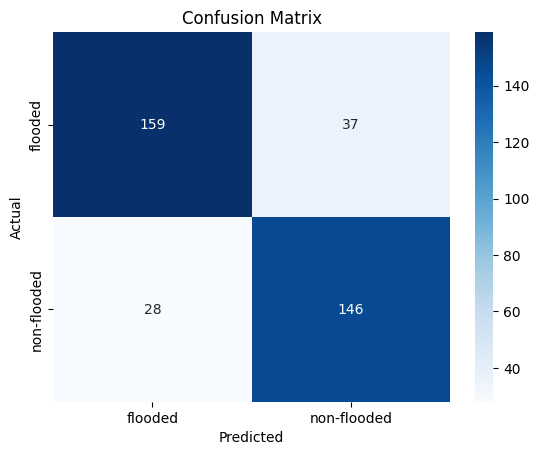

F1 Score: 0.8241


In [204]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = model.predict(X_val_aug)

y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# print the performance measures
print("F1 Score: {:.4f}".format(f1_score(y_val, y_pred, average="macro")))

### Save Model

In [206]:
# model.save("model.h5")

### load model

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model("model.h5")

### Evaluate On Test Data

In [209]:
# test the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("Test accuracy:", test_acc)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred, average="macro")))

3/3 - 1s - loss: 3.3235 - accuracy: 0.9054 - 1s/epoch - 356ms/step
Test accuracy: 0.9054054021835327
F1 Score: 0.9054


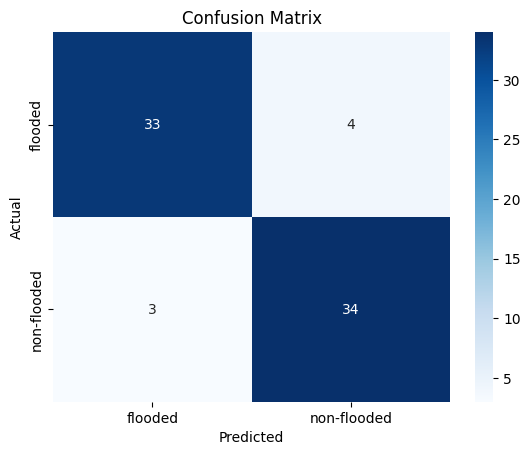

In [210]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Another Architecture

In [ ]:
# model = Sequential()
# # 1st layer (CONV + pool + batchnorm)
# model.add(
#     Conv2D(
#         filters=96,
#         kernel_size=(11, 11),
#         strides=(4, 4),
#         padding="valid",
#         input_shape=(227, 227, 3),
#     )
# )
# model.add(Activation("relu"))
# model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
# model.add(BatchNormalization())
# # 2nd layer (CONV + pool + batchnorm)
# model.add(
#     Conv2D(
#         filters=256,
#         kernel_size=(5, 5),
#         strides=(1, 1),
#         padding="same",
#         kernel_regularizer=l2(0.0005),
#     )
# )
# model.add(Activation("relu"))
# model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))
# model.add(BatchNormalization())
# # layer 3 (CONV + batchnorm)
# model.add(
#     Conv2D(
#         filters=384,
#         kernel_size=(3, 3),
#         strides=(1, 1),
#         padding="same",
#         kernel_regularizer=l2(0.0005),
#     )
# )
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# # layer 4 (CONV + batchnorm)
# model.add(
#     Conv2D(
#         filters=384,
#         kernel_size=(3, 3),
#         strides=(1, 1),
#         padding="same",
#         kernel_regularizer=l2(0.0005),
#     )
# )
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# # layer 5 (CONV + batchnorm)
# model.add(
#     Conv2D(
#         filters=256,
#         kernel_size=(3, 3),
#         strides=(1, 1),
#         padding="same",
#         kernel_regularizer=l2(0.0005),
#     )
# )
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))
# model.add(Flatten())
# # layer 6 (Dense layer + dropout)
# model.add(Dense(units=4096, activation="relu"))
# model.add(Dropout(0.5))
# # layer 7 (Dense layers)
# model.add(Dense(units=4096, activation="relu"))
# model.add(Dropout(0.5))
# # layer 8 (softmax output layer)
# model.add(Dense(units=2, activation="softmax"))